1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


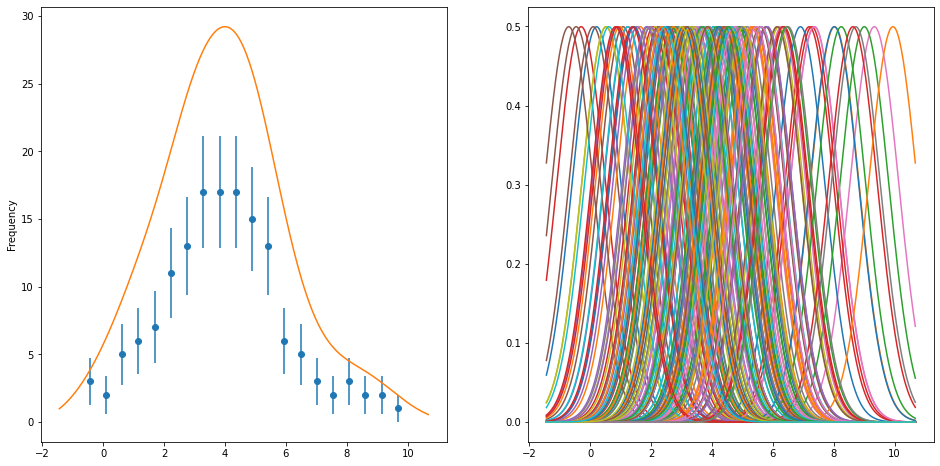

(149.30196829644913, 148.0)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm
from scipy.integrate import trapz


fig, (ax_1,ax_2) = plt.subplots(nrows=1,ncols=2, figsize = (16,8))

x = np.random.normal(4,2,150)
y_1, edges = np.histogram(x,bins = 20)
x_1 = (edges[1:]+edges[:-1])/2
ax_1.errorbar(x_1,y_1,yerr = y_1**0.5, fmt = 'o')

def major_tick(x, pos):
    if x % 1.0:
        return ""
    return int(x)

ax_1.yaxis.set_major_formatter(FuncFormatter(major_tick))
ax_1.set(ylabel='Frequency')
t = np.linspace(x_1.min()-1,x_1.max()+1,401)
# Apply gaussian
size, _std = x.size, x.std()
std = 1.06*_std*(size)**(-1/5)
kde = np.zeros(401)
for i in x:
    y = norm.pdf(t,i,std)
    ax_2.plot(t,y)
    kde = np.vstack([kde,y])
kde = np.sum(kde, axis = 0)#/trapz(kde)
ax_1.plot(t,kde)
plt.show()
trapz(kde, t), trapz(y_1)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

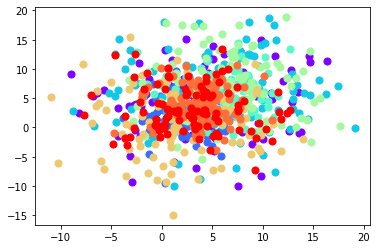

In [2]:
N = 8 # How many categories


## Color iterable taken from 
## https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
import matplotlib.cm as cm

x = np.arange(N)
ys = [i+x+(i*x)**2 for i in range(N)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
## We'll use this to guarantee each category gets their own color explicitly assigned,
## even though pyplot automatically assigns a different color on each iteration

def normal_2d(mu, sigma,d):
    x = np.random.normal(mu, sigma, d)
    y = np.random.normal(mu, sigma, d)
    return (x, y)

for i, c in zip(range(N),colors):
    mu = N*np.random.random()
    std = (N-1)*np.random.random()+1
    x, y = normal_2d(mu,std,100)
    plt.scatter(x,y, s = 50, color = c)
plt.show()

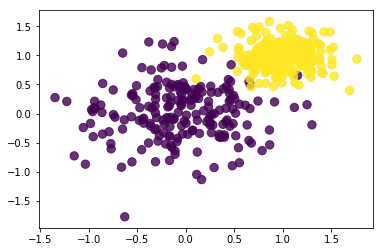

In [3]:
# wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [63]:
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
h = np.load("residuals_261.npy", allow_pickle = True)
df = pd.DataFrame(h.item())

# Inspect the dataset, you'll find two variables (features)
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


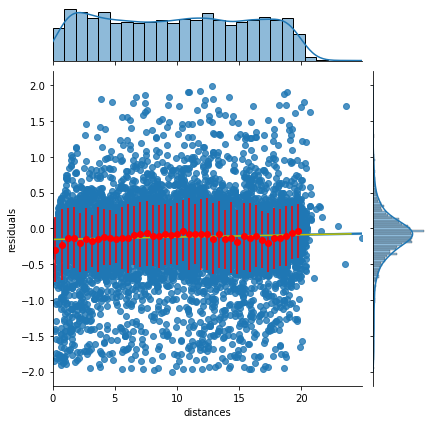

In [150]:
# Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
fil_df = df[abs(df['residuals'])<2]

# perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
m, b, r, p, std = linregress(fil_df['distances'],fil_df['residuals'])
distances = np.linspace(0,24,100)
residuals = m*distances+b

# plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
sns.jointplot(x = 'distances', y = 'residuals', data = fil_df, kind = 'reg')
plt.plot(distances,residuals, color= 'y')

# Fill 3 numpy arrays
red_df = fil_df[(fil_df['distances']<=20)*(fil_df['distances']>=0)]
red_df['my_bin'] = pd.cut(red_df['distances'], 41)

# x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
x = pd.Series(f.mid for f in red_df['my_bin'].unique()).sort_values()

# y, the mean values of the "residuals", estimated in slices (bins) of "distance"
y = red_df.groupby('my_bin')['residuals'].mean()

# erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
erry = red_df.groupby('my_bin')['residuals'].std()

# Plot the profile plot on top of the scatter plot
plt.errorbar(x,y,yerr = erry, fmt = 'o', color = 'r')
plt.show()